# Citation Usage Event Data

In [1]:
# basic defaults, including study dates, common SQL exclusions and parquet files for anonymized data
%run -i 'data-defaults.py'

def get_stats(df,groupby):
    all_events_count = df['count'].sum()
    stats = df.groupby(groupby).agg(
    [('days','count'),
    ('total_events','sum'),
    'mean', 
    'median', 
    'min', 
    'max', 
    'std', 
    ('25%', lambda x: x.quantile(.25)), 
    ('50%', lambda x: x.quantile(.5)), 
    ('75%', lambda x: x.quantile(.75)),
    ('perc', lambda x: sum(x)/all_events_count)])
    stats.columns = stats.columns.droplevel()
    return stats.reset_index()

## Overview

### Events by date and type

In [2]:
# show citationusage events by date and type
events_query = """
SELECT to_date(event_time) date,
        CASE 
            WHEN action='extClick' AND footnote_number IS NOT NULL THEN "extClickReference" 
            ELSE action
        END eventType, 
        COUNT(*) count
FROM citationusage
WHERE wiki = 'enwiki'
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
GROUP BY to_date(event_time), eventType
ORDER BY to_date(event_time)
"""

events = spark.sql(events_query.format(event_exclusion_sql,start_date_string, end_date_string))
events_rdd = events.rdd
events_df = sqlContext.createDataFrame(events_rdd)
events_pandas = events_df.toPandas()

In [3]:
events_pandas.pivot(index='date', columns='eventType', values='count')

eventType,extClick,extClickReference,fnClick,fnHover,upClick
date,,,,,
2019-03-22,1030831,533445,725377,1131859,149622
2019-03-23,942311,427086,667724,883147,20342
2019-03-24,1019073,490253,750329,1018411,23969
2019-03-25,1141175,603626,782508,1365524,82990
2019-03-26,1119357,582303,737057,1342285,28909
2019-03-27,1096054,570302,728824,1321898,27761
2019-03-28,1063729,548121,705904,1267787,25736
2019-03-29,1004613,494275,666005,1122572,23467
2019-03-30,928308,407724,649300,865928,19934


### Events for WP:M pages with external links

In [4]:
# daily count of events for WP:M pages with external links over study period
wpm_events_query = """
SELECT to_date(event_time) date,
        CASE 
            WHEN action='extClick' AND footnote_number IS NOT NULL THEN "extClickReference" 
            ELSE action
        END eventType, 
        COUNT(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
{}
AND day = {}
AND month = {}
AND year = {}
AND useragent_is_bot = FALSE
GROUP BY to_date(event_time), eventType
ORDER BY to_date(event_time)
"""

wpm_events_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    dt = date_to_dt(d)
    daily_wpm_events = spark.sql(
        wpm_events_query.format(event_exclusion_sql, d.day, d.month, d.year))
    wpm_events_rdd = wpm_events_rdd.union(daily_wpm_events.rdd)

wpm_events_merged = sqlContext.createDataFrame(wpm_events_rdd)
wpm_events = wpm_events_merged.toPandas()

#### WP:M event summary

In [5]:
# summary of events for WP:M pages with external links
get_stats(wpm_events,['eventType'])

,eventType,days,total_events,mean,median,min,max,std,25%,50%,75%,perc
0,extClick,32,319419,9981.84375,10468.5,7310,11783,1550.585373,8344.50,10468.5,11249.50,0.096127
1,extClickReference,32,506562,15830.06250,16836.5,10984,19005,2675.956465,13532.00,16836.5,17943.00,0.152447
2,fnClick,32,887662,27739.43750,28612.0,22608,31122,2626.223334,25830.75,28612.0,29741.75,0.267137
3,fnHover,32,1559965,48748.90625,48772.5,32894,60269,8621.973440,41783.50,48772.5,56687.50,0.469463
4,upClick,32,49263,1539.46875,913.5,621,12580,2227.803402,820.00,913.5,1132.25,0.014825


#### WP:M daily events

In [6]:
# daily event counts for WPM:M pages with external links
wpm_events.pivot(index='date', columns='eventType', values='count')

eventType,extClick,extClickReference,fnClick,fnHover,upClick
date,,,,,
2019-03-22,10422,16708,27753,47375,5851
2019-03-23,8352,12119,23852,37786,683
2019-03-24,9175,14200,26987,44589,896
2019-03-25,11564,18834,29599,59335,1235
2019-03-26,11783,18785,30422,60269,1051
2019-03-27,11656,18051,30741,59600,971
2019-03-28,11154,18528,29298,56639,929
2019-03-29,9610,14917,25752,46813,830
2019-03-30,7310,11337,22608,36714,659


### Events for W pages with external links

In [7]:
# daily count of events for W pages with ext links over study period
w_events_query = """
SELECT to_date(event_time) date,
        CASE 
            WHEN action='extClick' AND footnote_number IS NOT NULL THEN "extClickReference" 
            ELSE action
        END eventType, 
        COUNT(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
{}
AND day = {}
AND month = {}
AND year = {}
AND useragent_is_bot = FALSE
GROUP BY to_date(event_time), eventType
ORDER BY to_date(event_time)
"""

w_events_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    dt = date_to_dt(d)
    daily_w_events = spark.sql(
        w_events_query.format(event_exclusion_sql, d.day, d.month, d.year))
    w_events_rdd = w_events_rdd.union(daily_w_events.rdd)

w_events_merged = sqlContext.createDataFrame(w_events_rdd)
w_events = w_events_merged.toPandas()

#### W event summary

In [8]:
# summary of events for W pages with external links
get_stats(w_events,['eventType'])

,eventType,days,total_events,mean,median,min,max,std,25%,50%,75%,perc
0,extClick,32,33648316,1051509,1057473,920420,1158344,65816.967470,1007678.25,1057473,1103263,0.305965
1,extClickReference,32,16179573,505611,522769,396162,593818,60558.250099,455157.25,522769,554658,0.147121
2,fnClick,32,23108212,722131,723895,624928,820998,46869.018210,695899.75,723895,752815,0.210124
3,fnHover,32,35926529,1122704,1165469,826976,1481295,185086.791800,964512.25,1165469,1279761,0.326681
4,upClick,32,1111622,34738,25724,19026,143458,24483.350241,22709.50,25724,35897,0.010108


#### W daily events

In [9]:
# daily event counts for W pages with external links
w_events.pivot(index='date', columns='eventType', values='count')

eventType,extClick,extClickReference,fnClick,fnHover,upClick
date,,,,,
2019-03-22,1019630,516275,695599,1081404,143458
2019-03-23,933276,414609,641895,843147,19347
2019-03-24,1009220,475709,720997,971081,22756
2019-03-25,1128885,584386,750599,1302415,81252
2019-03-26,1106832,563151,704416,1278722,27362
2019-03-27,1083759,551966,696000,1259035,26375
2019-03-28,1051910,529263,674494,1208129,24435
2019-03-29,994438,479092,638280,1073015,22314
2019-03-30,920420,396162,624928,826976,19026


## Mobile vs Desktop

### mobile vs desktop events for W pages with external links

In [10]:
# mobile vs desktop events for W pages with external links
w_mode_events_query = """
SELECT to_date(event_time) AS date, 
        mode,
        CASE 
            WHEN action='extClick' AND footnote_number IS NOT NULL THEN "extClickReference" 
            ELSE action
        END eventType, 
        COUNT(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
GROUP BY date, mode, eventType
ORDER BY date, mode, eventType
"""

events = spark.sql(w_mode_events_query.format(event_exclusion_sql,start_date_string, end_date_string))
events_rdd = events.rdd
events_df = sqlContext.createDataFrame(events_rdd)
w_events_pandas = events_df.toPandas()
get_stats(w_events_pandas,['mode','eventType'])

,mode,eventType,days,total_events,mean,median,min,max,std,25%,50%,75%,perc
0,desktop,extClick,32,18139374,5.668554e+05,594753.0,419094,675799,92081.872066,469024.25,594753.0,643869.75,0.164942
1,desktop,extClickReference,32,11154869,3.485897e+05,379397.5,238213,427173,68519.480695,280904.75,379397.5,405439.75,0.101432
2,desktop,fnClick,32,7527839,2.352450e+05,255253.5,162052,309010,43789.385081,195226.00,255253.5,267710.25,0.068451
3,desktop,fnHover,32,33855425,1.057982e+06,1097533.0,766685,1416905,185721.887148,897499.25,1097533.0,1215819.50,0.307849
4,desktop,upClick,32,999363,3.123009e+04,22426.5,15554,140145,24533.609128,19123.75,22426.5,32551.50,0.009087
5,mobile,extClick,32,15508942,4.846544e+05,479716.0,423654,577730,44389.300428,443105.25,479716.0,523287.00,0.141023
6,mobile,extClickReference,32,5024704,1.570220e+05,153651.0,137611,187101,14044.896532,145693.75,153651.0,168927.50,0.045690
7,mobile,fnClick,32,15580373,4.868867e+05,480579.0,416481,595415,47949.474529,442803.75,480579.0,519503.25,0.141673
8,mobile,fnHover,32,2071104,6.472200e+04,64384.0,57461,72650,3955.892616,62148.75,64384.0,67267.25,0.018833
9,mobile,upClick,32,112259,3.508094e+03,3466.5,2987,4127,258.408199,3315.25,3466.5,3713.75,0.001021


### mobile vs desktop events for WP:M pages with external links

In [11]:
# mobile vs desktop events for WP:M pages with external links
wpm_mode_events_query = """
SELECT to_date(event_time) AS date, 
        mode,
        CASE 
            WHEN action='extClick' AND footnote_number IS NOT NULL THEN "extClickReference" 
            ELSE action
        END eventType, 
        COUNT(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
GROUP BY date, mode, eventType
ORDER BY date, mode, eventType
"""

events = spark.sql(wpm_mode_events_query.format(event_exclusion_sql,start_date_string, end_date_string))
events_rdd = events.rdd
events_df = sqlContext.createDataFrame(events_rdd)
wpm_events_pandas = events_df.toPandas()
get_stats(wpm_events_pandas,['mode','eventType'])

,mode,eventType,days,total_events,mean,median,min,max,std,25%,50%,75%,perc
0,desktop,extClick,32,169266,5289.56250,5756.0,2960,6922,1386.818590,3731.25,5756.0,6461.75,0.050940
1,desktop,extClickReference,32,400086,12502.68750,13618.0,7879,15375,2526.970639,10335.00,13618.0,14579.25,0.120404
2,desktop,fnClick,32,350362,10948.81250,11809.5,6992,13387,2039.249885,9359.25,11809.5,12495.75,0.105440
3,desktop,fnHover,32,1466075,45814.84375,45790.5,30290,56944,8395.114932,38803.50,45790.5,53479.75,0.441207
4,desktop,upClick,32,45528,1422.75000,787.5,530,12492,2232.108652,711.00,787.5,982.00,0.013701
5,mobile,extClick,32,150153,4692.28125,4694.0,4080,5275,284.126418,4473.50,4694.0,4905.50,0.045188
6,mobile,extClickReference,32,106476,3327.37500,3320.5,2936,3685,204.813015,3176.00,3320.5,3482.75,0.032043
7,mobile,fnClick,32,537300,16790.62500,16899.0,14864,18461,887.853764,16156.00,16899.0,17294.25,0.161698
8,mobile,fnHover,32,93890,2934.06250,2937.5,2542,3421,265.305902,2690.75,2937.5,3159.75,0.028256
9,mobile,upClick,32,3735,116.71875,118.0,88,155,16.142979,106.00,118.0,127.00,0.001124


## Visualization

In [12]:
# Plots inline
%matplotlib inline

In [13]:
w_events_info = get_stats(w_events_pandas,['mode', 'eventType'])
w_events_info['group'] = "W"
wm_events_info = get_stats(wpm_events_pandas,['mode', 'eventType'])
wm_events_info['group'] = "WP:MED"

all_stats = w_events_info.append(wm_events_info)
all_stats.head()

,mode,eventType,days,total_events,mean,median,min,max,std,25%,50%,75%,perc,group
0,desktop,extClick,32,18139374,5.668554e+05,594753.0,419094,675799,92081.872066,469024.25,594753.0,643869.75,0.164942,W
1,desktop,extClickReference,32,11154869,3.485897e+05,379397.5,238213,427173,68519.480695,280904.75,379397.5,405439.75,0.101432,W
2,desktop,fnClick,32,7527839,2.352450e+05,255253.5,162052,309010,43789.385081,195226.00,255253.5,267710.25,0.068451,W
3,desktop,fnHover,32,33855425,1.057982e+06,1097533.0,766685,1416905,185721.887148,897499.25,1097533.0,1215819.50,0.307849,W
4,desktop,upClick,32,999363,3.123009e+04,22426.5,15554,140145,24533.609128,19123.75,22426.5,32551.50,0.009087,W


In [14]:
events_by_group = all_stats.groupby(["eventType", "group"]).agg("sum")[["perc", "total_events"]].reset_index()
events_by_group["daily_average"] = events_by_group["total_events"]/32
events_by_group.head()

,eventType,group,perc,total_events,daily_average
0,extClick,W,0.305965,33648316,1.051510e+06
1,extClick,WP:MED,0.096127,319419,9.981844e+03
2,extClickReference,W,0.147121,16179573,5.056117e+05
3,extClickReference,WP:MED,0.152447,506562,1.583006e+04
4,fnClick,W,0.210124,23108212,7.221316e+05


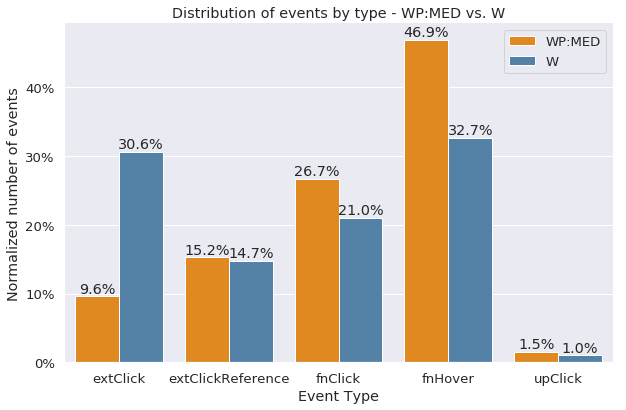

In [16]:
sns.set(font_scale=1.2)

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.005
            value = '{:,.1%}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


my_pal = {"WP:MED": "darkorange", "W": "steelblue"}
fig = sns.catplot(y='perc', x='eventType', hue='group', 
                data=events_by_group, kind='bar', palette=my_pal, 
                  legend=False, hue_order=["WP:MED", "W"])
fig.ax.set(xlabel='Event Type', ylabel='Normalized number of events', 
           title="Distribution of events by type - WP:MED vs. W")
fig.ax.ticklabel_format(style='plain', axis='y')
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.gcf().set_size_inches(10, 6)
plt.legend(loc='upper right')

show_values_on_bars(fig.ax)
plt.savefig("events_distribution.pdf")

